In [2]:
from glob import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu,ranksums

from matplotlib import pyplot
import seaborn as sns
import os   
import matplotlib as mpl

import matplotlib.font_manager as font_manager
font_dir = ['/home/luosongwen/scantecc/ttf/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
from statannotations.Annotator import Annotator
from matplotlib import gridspec,cm
from scipy import stats as ss
import multiprocessing as mp

### Figure2A Normalized counts of large-size cell-free eccDNA (length >1 kb) detected in healthy individuals and patients across multiple cancer types.

In [3]:
S4a = pd.read_table("/home/luosongwen/scantecc/s4a_new.txt", index_col=0)

# 创建映射字典，将中文类别映射为对应的英文
mapping = {
    "正常对照": "Health",
    "肺癌": "Lung",
    "卵巢癌": "Ovarian",
    "胃癌": "Gastric",
    "淋巴瘤": "Lymphoma",
    "结直肠癌": "Colorectal",
    "乳腺癌": "Breast",
    "other": "Others"
}
# 使用 replace 函数进行替换
S4a['ctype'] = S4a['ctype'].replace(mapping)

# 定义目标顺序
order = ["Health", "Lung", "Ovarian", "Gastric", "Lymphoma", "Colorectal", "Breast", "Others"]

# 将 ctype 列转化为分类类型，并按照 order 排序
S4a['ctype'] = pd.Categorical(S4a['ctype'], categories=order, ordered=True)

# 按照新的顺序排序 S4a 数据框
S4a_sorted = S4a.sort_values('ctype')

In [4]:
S4a_sorted

,final_epm,ctype,label,final_epm_without_hc,state
送测编号,,,,,
SE-169,5.366242,Health,Normal,5.543510,NaN
SE-37,6.345796,Health,Normal,6.442067,NaN
SE-23,4.992009,Health,Normal,5.169198,NaN
SE-179,5.343086,Health,Normal,5.534572,NaN
SE-186,5.020666,Health,Normal,5.210268,NaN
...,...,...,...,...,...
HG605,12.112514,Others,Disease,13.935468,4
HG454,5.238286,Others,Disease,6.062286,4
HG53,9.275205,Others,Disease,10.361490,1


/tmp/ipykernel_48836/499254321.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_48836/499254321.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Health vs. Lung: t-test independent samples, P_val:4.171e-20 t=-9.661e+00
Health vs. Ovarian: t-test independent samples, P_val:7.101e-15 t=-8.191e+00
Health vs. Gastric: t-test independent samples, P_val:5.660e-15 t=-8.260e+00
Health vs. Lymphoma: t-test independent samples, P_val:3.381e-22 t=-1.057e+01
Health vs. Colorectal: t-test independent samples, P_val:4.830e-26 t=-1.184e+01
Health vs. Breast: t-test independent samples, P_val:1.060e-22 t=-1.086e+01
Health vs. Others: t-test independent samples, P_val:1.556e-11 t=-7.039e+00


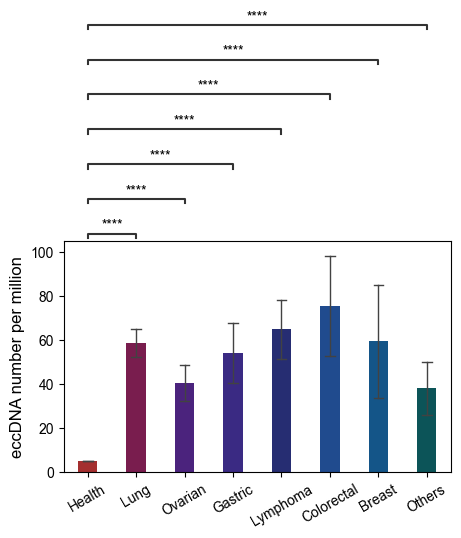

In [5]:
# 创建画布和坐标轴
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# 使用 barplot 替代 boxplot，添加误差线为标准误差（sem）
sns.barplot(
    data=S4a_sorted,
    x='ctype', y='final_epm_without_hc',
    errorbar='se',  # 设置误差线为标准误差
    ax=ax,
    capsize=0.2,
    errwidth=1, width=0.4,
    palette=['#b71c1c', '#880e4f', '#4a148c', '#311b92', '#1a237e', '#0d47a1', '#01579b', '#006064']
)

# 叠加散点图
#sns.stripplot(
    #data=filtered_eccDNA_count_df,
    #x='ctype', y='epm', ax=ax,
    #marker='o', color='k', size=4, alpha=0.8,
    #palette=['#661212', '#4c092f', '#260c4c', '#160f4c', '#0d133f', '#07234c', '#012e4c', '#003333']
#)

# 添加显著性标记
box_pairs = [
    ("Health", "Lung"),
    ("Health", "Ovarian"),
    ("Health", "Gastric"),
    ("Health", "Lymphoma"),
    ("Health", "Colorectal"),
    ("Health", "Breast"),
    ("Health", "Others"),
]

annot = Annotator(ax, box_pairs, data=S4a_sorted, x="ctype", y="final_epm_without_hc")
annot.configure(test='t-test_ind', text_format='star', loc='outside')
annot.apply_and_annotate()

# 设置标签
plt.xlabel("")
plt.ylabel("eccDNA number per million", fontsize=12)
plt.xticks(rotation=30)
plt.ylim(0,105)
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/Figure2a_barplot_without_stripplot.pdf', bbox_inches='tight')

# 显示图形
plt.show()

### Fig2B Enrichment of known cancer-associated driver genes in specific cancer types based on large-size cell-free eccDNA

In [3]:
data = pd.read_table("/home/luosongwen/scantecc/Fold-Change.txt",index_col = 0)
data["Condition"] = data.index
data = data.drop(columns=["0"])

In [9]:
# 为列指定名称
data.columns = ['Fold_Change_1', 'Fold_Change_2', 'Fold_Change_3', 'Fold_Change_4', 'Fold_Change_5', 'Fold_Change_6', 'Condition']

# 将数据转换为长格式，方便绘图
data_long = pd.melt(data, id_vars=["Condition"], value_vars=["Fold_Change_1", "Fold_Change_2", "Fold_Change_3", "Fold_Change_4", "Fold_Change_5", "Fold_Change_6"],
                    var_name="Measurement", value_name="Fold_Change")

/tmp/ipykernel_48836/3635863975.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

non_sizeup vs. sizeup: t-test independent samples, P_val:4.399e-04 t=-5.137e+00


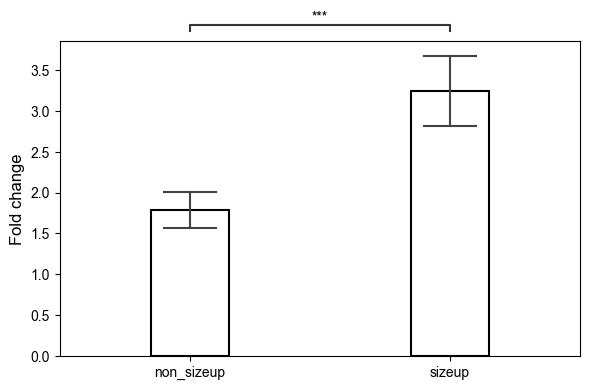

In [10]:
# 创建柱状图（替换箱线图）
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=data_long, x='Condition', y='Fold_Change',
    width=0.3,             # 设置柱子的宽度
    edgecolor='black',     # 设置边框颜色
    linewidth=1.5,         # 设置边框线宽
    capsize=0.2,           # 设置误差线帽宽度
    errwidth=1.5,          # 设置误差线宽度
    color='white'          # 填充为白色，与原来boxplot白色一致
)

# 添加显著性标记，假设进行两组条件的比较
pairs = [("non_sizeup", "sizeup")]

# 创建 Annotator 对象，进行显著性标记
annotator = Annotator(ax, pairs, data=data_long, x='Condition', y='Fold_Change')
annotator.configure(test='t-test_ind', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

# 添加标题和标签
plt.ylabel('Fold change', fontsize=12)
plt.xlabel('', fontsize=12)

# 设置图形显示样式
plt.tight_layout()

# 显示图形
# plt.savefig("/home/luosongwen/scantecc/supplementary_figure/Sfig4B.pdf")
plt.show()

/tmp/ipykernel_48836/2375248184.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_48836/2375248184.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

non_sizeup vs. sizeup: t-test independent samples, P_val:4.399e-04 t=-5.137e+00


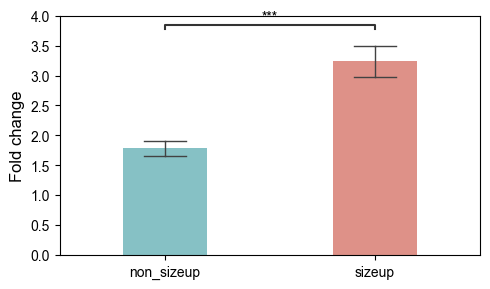

In [11]:
# 创建画布和坐标轴
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# 使用 barplot 替代 boxplot，添加误差线为标准误差（sem）
sns.barplot(
    data=data_long,
    x='Condition', y='Fold_Change',
    errorbar='se',  # 设置误差线为标准误差
    ax=ax,
    capsize=0.2,
    errwidth=1, width=0.4,
    palette=['#7ccacf', '#ec867a']
)

# 添加显著性标记
box_pairs = [("non_sizeup", "sizeup")]
annot = Annotator(ax, box_pairs, data=data_long, x="Condition", y="Fold_Change")
annot.configure(test='t-test_ind', text_format='star', loc='outside')
annot.apply_and_annotate()

# 设置标签
plt.xlabel("")
plt.ylabel("Fold change", fontsize=12)

# 设置 Y 轴范围和刻度
ax.set_ylim(0, 4)
ax.set_yticks([i * 0.5 for i in range(9)])  # 即 [0.0, 0.5, ..., 4.0]

# 显示图形
plt.tight_layout()
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/Figure2b_barplot_without_stripplot.pdf', bbox_inches='tight')
plt.show()